<center><h3><b>Machine learning model-based early detection<br>of acute kidney injury in hypertensive patients
</b></h3></center>

#### **Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Standardization packages
from sklearn.preprocessing import StandardScaler

# Machine learning packages
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Model selection packages
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

# Model validation packages
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.calibration import calibration_curve

# Statistical analysis packages
from scipy.stats import kstest, ttest_ind, chi2_contingency

# Formatting packages
from prettytable import PrettyTable
from collections import defaultdict

import shap

pd.set_option('display.max_rows', None)

In [2]:
from google.colab import auth
from google.colab import data_table
from google.cloud import bigquery

# Access to the project in Google Cloud
data_table.enable_dataframe_formatter()

auth.authenticate_user()
print('Authenticated')

project_id = "axial-matter-431303-b1"
client = bigquery.Client(project = project_id)

Authenticated


### **Data collection**

#### Identifying hypertensive patients who developed acute kidney injury<br> during their first hospital admission

##### Finding hypertensive patients.
    Definition: In this project, patients taking antihypertensive medications are classified as hypertensive patients. The mediciations referenced are based on the list provided by the Amercian Heart Association. Source: https://www.heart.org/en/health-topics/high-blood-pressure/changes-you-can-make-to-manage-high-blood-pressure/types-of-blood-pressure-medications

In [3]:
query = """
  SELECT
    adm.subject_id,
    adm.hadm_id,
    adm.admittime,
    emar.medication
  FROM
    physionet-data.mimiciv_hosp.admissions adm
  JOIN
    physionet-data.mimiciv_hosp.emar emar
    ON (adm.subject_id = emar.subject_id)
    AND (adm.hadm_id = emar.hadm_id)

  WHERE
    LOWER(emar.medication) LIKE ANY (
      # Diuretics
      '%furosemide%', '%lasix%', '%bumetanide%',
      '%torsemide%', '%demadex%', '%chlorothiazide%',
      '%amiloride%', '%chlorthalidone%', '%hygroton%',
      '%hydrochlorothiazide%', '%hctz%', '%esidrix%',
      '%hydrodiuril%', '%indapamide%', '%lozol%',
      '%metolazone%', '%zaroxolyn%', '%triamterene%', '%dyrenium%',

      # Beta-blockers
      '%acebutolol%', '%sectral%', '%atenolol%', '%tenormin%',
      '%betaxolol%', '%bisoprolol%', '%carvedilol%', '%coreg%',
      '%coreg cr%', '%labetalol%', '%trandate%', '%metoprolol succinate%',
      '%toprol xl%', '%kapspargo sprinkle%', '%metoprolol tartrate%',
      '%lopressor%', '%nadolol%', '%corgard%', '%nebivolol%',
      '%bystolic%', '%pindolol%', '%visken%', '%propranolol%',
      '%inderal%', '%inderal la%', '%innopran xl%',

      # Angiotensin-converting enzyme inhibitors(ACE inhibitors)
      '%captopril%', '%capoten%', '%enalapril%', '%vasotec%',
      '%fosinopril%', '%monopril%', '%lisinopril%', '%prinivil%',
      '%zestril%', '%perindopril%', '%aceon%', '%quinapril%',
      '%accupril%', '%ramipril%', '%altace%', '%trandolapril%',
      '%mavik%', '%benazepril%', '%lotensin%', '%moexipril%', '%univasc%',

      # Angiotensin II receptor blockers (ARBs)
      '%candesartan%', '%atacand%', '%losartan%', '%cozaar%',
      '%valsartan%', '%diovan%',

      # Calcium channel blockers
      '%amlodipine%', '%norvasc%', '%lotrel%', '%diltiazem%',
      '%cardizem cd%', '%cardizem sr%', '%dilacor xr%', '%tiazac%',
      '%felodipine%', '%plendil%', '%isradipine%', '%dynacirc%',
      '%dynacirc cr%', '%nicardipine%', '%cardene sr%', '%nifedipine la%',
      '%adalat cc%', '%procardia xl%', '%nisoldipine%', '%sular%',
      '%verapamil%', '%calan sr%', '%covera hs%', '%isoptin sr%', '%verelan%',

      # Alpha blockers
      '%doxazosin%', '%cardura%', '%prazosin%', '%minipress%',
      '%terazosin hydrochloride%', '%hytrin%',

      # Central alpha-2 receptor agonists and other centrally acting medications
      '%methyldopa%', '%aldomet%', '%clonidine%', '%catapres%',
      '%duraclon%', '%kapvay%', '%nexiclon xr%', '%guanfacine%',
      '%intuniv%', '%tenex%',

      # Combined alpha and beta-blockers
      '%carvedilol%', '%coreg%', '%labetalol hydrochloride%',
      '%normodyne%', '%trandate%',

      # Blood vessel dilators (vasodilators)
      '%hydralazine%', '%apresoline%', '%minoxidil%', '%loniten%'

    )

    AND adm.subject_id IS NOT NULL
    AND adm.hadm_id IS NOT NULL
    AND adm.admittime IS NOT NULL

  ORDER BY
    adm.subject_id, adm.hadm_id, adm.admittime
"""

query_job = client.query(query)
bp_med_recs = query_job.to_dataframe()
print(f"{len(bp_med_recs)} antihypertensive medication records")
bp_med_recs.head()

1727997 antihypertensive medication records


,subject_id,hadm_id,admittime,medication
0,10000032,22595853,2180-05-06 22:23:00,Furosemide
1,10000032,22595853,2180-05-06 22:23:00,Furosemide
2,10000032,22841357,2180-06-26 18:27:00,Furosemide
3,10000032,25742920,2180-08-05 23:44:00,Furosemide
4,10000032,25742920,2180-08-05 23:44:00,Furosemide


In [4]:
# Find out the first admission information (i.e., subject_id, hadm_id) to these hypertensive patients

htn_patients = (

    bp_med_recs.copy()
    .assign(admittime=pd.to_datetime(bp_med_recs['admittime']))
    .sort_values(by=['subject_id', 'admittime'])

    # Keep only the first admission per patient
    .drop_duplicates(subset='subject_id', keep='first')
    [['subject_id', 'hadm_id', 'admittime']]
    .reset_index(drop=True)
)

print(f"{len(htn_patients)} hypertensive patients")
htn_patients.head()

55065 hypertensive patients


,subject_id,hadm_id,admittime
0,10000032,22595853,2180-05-06 22:23:00
1,10000764,27897940,2132-10-14 23:31:00
2,10000980,24947999,2190-11-06 20:57:00
3,10001401,21544441,2131-06-04 00:00:00
4,10001667,22672901,2173-08-22 17:16:00


##### Finding creatinine records to hypertensive patients (both in ICU module and HOSP module)

In [5]:
query = """

  # Find out all serum creatinine records in ICU module
  SELECT
    char.subject_id,
    char.hadm_id,
    dlab.label,
    char.valuenum AS value,
    char.charttime
  FROM
    physionet-data.mimiciv_icu.chartevents AS char
  INNER JOIN
    physionet-data.mimiciv_icu.d_items AS dlab
    ON char.itemid = dlab.itemid
  WHERE
    dlab.label like '%Creatinine (serum)%'

  UNION ALL

  # Find out all serum creatinine records in HOSP module
  SELECT
    le.subject_id,
    le.hadm_id,
    dlab.label,
    le.valuenum AS value,
    le.charttime
  FROM
    physionet-data.mimiciv_hosp.labevents AS le
  INNER JOIN
    physionet-data.mimiciv_hosp.d_labitems AS dlab
    ON le.itemid = dlab.itemid
  WHERE
    dlab.label LIKE '%Creatinine, Serum%'
    AND le.hadm_id IS NOT NULL

  ORDER BY
    subject_id, charttime
"""

creatinine_records = client.query(query).to_dataframe()
print(f"{len(creatinine_records)} creatinine records")
creatinine_records.head()

425647 creatinine records


,subject_id,hadm_id,label,value,charttime
0,10000032,29079034,Creatinine (serum),0.5,2180-07-23 21:45:00
1,10001217,24597018,Creatinine (serum),0.4,2157-11-21 03:16:00
2,10001217,27703517,Creatinine (serum),0.5,2157-12-20 01:45:00
3,10001725,25563031,Creatinine (serum),0.8,2110-04-11 18:02:00
4,10001725,25563031,Creatinine (serum),0.8,2110-04-12 02:59:00


In [6]:
# Inner join the hypertensive patients table and the creatinine records table

htn_creatinine = (

      pd.merge(htn_patients, creatinine_records, on=['subject_id', 'hadm_id'], how='inner')
      .reset_index(drop=True)
)

print(f"{len(list(htn_creatinine['subject_id'].unique()))} hypertensive patients had {len(htn_creatinine)} creatinine records during first admission")
htn_creatinine.head()

15741 hypertensive patients had 124181 creatinine records during first admission


,subject_id,hadm_id,admittime,label,value,charttime
0,10002348,22725460,2112-11-30 22:22:00,Creatinine (serum),0.8,2112-12-01 06:36:00
1,10002348,22725460,2112-11-30 22:22:00,Creatinine (serum),0.8,2112-12-03 06:36:00
2,10002348,22725460,2112-11-30 22:22:00,Creatinine (serum),0.8,2112-12-04 06:50:00
3,10002348,22725460,2112-11-30 22:22:00,Creatinine (serum),0.9,2112-12-05 02:53:00
4,10002348,22725460,2112-11-30 22:22:00,Creatinine (serum),0.8,2112-12-06 00:17:00


##### Diagnosing acute kidney injury in hypertensive patients base on creatinine change
    Definition: According to KDIGO guidelines, one of the criteria is
    "Increase in serum creatinine by >= 0.3 mg/dL within 48 hours".

In [7]:
def creatinine_change(patient_records):

  # Create a 48-hour rolling window
  patient_records.set_index('charttime', inplace=True)
  rolling_window = pd.Series(patient_records['value']).rolling('48h')

  # Calculate the max - min within the window
  patient_records['Serum_creat_change'] = round(rolling_window.max() - rolling_window.min(), 3)

  return patient_records



# Find out all patients who had a significant change in serum creatine >= 0.3 mg/dL within 48 hrs
aki_patients_scr = (

    htn_creatinine.copy()

    # Group the records by each patient and apply the 'creatinine_change' function
    .groupby(['subject_id'], group_keys=False)
    .apply(creatinine_change)

    # Add a new column 'aki' to flag patients with acute kidney injury (AKI)
    .assign(aki=lambda df: np.where(df['Serum_creat_change'] >= 0.3, 1, 0))

    # Filter the rows where AKI is detected
    .loc[lambda df: df['aki'] == 1]

    [['subject_id', 'hadm_id', 'admittime']]
    .drop_duplicates()
    .reset_index(drop=True)
)


print(f"{len(aki_patients_scr)} hypertensive patients who developed AKI\nduring first admission based on the serum creatinine change >= 0.3 mg/dL within 48 hours.\n\n")
aki_patients_scr.head()

5974 hypertensive patients who developed AKI
during first admission based on the serum creatinine change >= 0.3 mg/dL within 48 hours.




<ipython-input-7-b83ecd5e74ef>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(creatinine_change)


,subject_id,hadm_id,admittime
0,10002443,21329021,2183-10-17 23:20:00
1,10002495,24982426,2141-05-22 20:17:00
2,10004235,24181354,2196-02-24 14:38:00
3,10004733,27411876,2174-12-04 11:28:00
4,10004764,24817563,2168-04-11 19:16:00


##### Finding urine output records to hypertensive patients (both in ICU module and HOSP module)

In [8]:
query = """

  WITH urine_records as (

    # Find out urine output records from ICU module
    SELECT
      oe.subject_id,
      oe.hadm_id,
      dlab.label,
      oe.value AS urine_output,
      oe.charttime,
      AVG(ie.patientweight) AS mean_weight_kg

    FROM
      physionet-data.mimiciv_icu.outputevents AS oe
    JOIN
      physionet-data.mimiciv_icu.d_items AS dlab
      ON oe.itemid = dlab.itemid
    JOIN
      physionet-data.mimiciv_icu.inputevents AS ie
      ON oe.subject_id = ie.subject_id
      AND oe.hadm_id = ie.hadm_id
    WHERE
      dlab.label LIKE "Foley%"
    GROUP BY
      oe.subject_id, oe.hadm_id, dlab.label, oe.value, oe.charttime

    UNION ALL

    # Find out urine output records from HOSP module
    SELECT
      le.subject_id,
      le.hadm_id,
      dlab.label,
      le.valuenum AS urine_output,
      le.charttime,

      # 1 pound (lb) is approximately 0.453592 kilograms (kg)
      ROUND(AVG(CAST(omr.result_value AS FLOAT64))*0.453592, 3) AS mean_weight_kg

    FROM
      physionet-data.mimiciv_hosp.labevents AS le
    JOIN
      physionet-data.mimiciv_hosp.d_labitems AS dlab
      ON le.itemid = dlab.itemid
    JOIN
      physionet-data.mimiciv_hosp.omr AS omr
      ON le.subject_id = omr.subject_id
    WHERE
      lower(dlab.label) like '%urine volume%'
      AND omr.result_name = 'Weight (Lbs)'
      AND le.hadm_id IS NOT NULL
    GROUP BY
      le.subject_id, le.hadm_id, le.charttime,
      le.valuenum, le.valueuom, dlab.label, dlab.fluid

    ORDER BY
      subject_id, charttime
  )

  SELECT
    *,
    round(urine_output / mean_weight_kg, 3) AS urine_per_kg_hr
  FROM
    urine_records
  ORDER BY
    subject_id, charttime

  """

query_job = client.query(query)
urine_output = query_job.to_dataframe()
print(f"{len(urine_output)} urine output records in based on catheterisation")
urine_output.head()

2980204 urine output records in based on catheterisation


,subject_id,hadm_id,label,urine_output,charttime,mean_weight_kg,urine_per_kg_hr
0,10000826,28289260,Urine Volume,400.0,2147-01-02 10:47:00,60.37,6.626
1,10000980,26913865,Foley,450.0,2189-06-27 09:08:00,76.20,5.906
2,10000980,26913865,Foley,600.0,2189-06-27 11:00:00,76.20,7.874
3,10000980,26913865,Foley,800.0,2189-06-27 13:00:00,76.20,10.499
4,10000980,26913865,Foley,1000.0,2189-06-27 14:00:00,76.20,13.123


In [9]:
# Inner join the hypertensive patients table and the icu urine output table

htn_urine = (

      pd.merge(htn_patients, urine_output, on=['subject_id', 'hadm_id'], how='inner')
      .query('urine_per_kg_hr != 0')
      .reset_index(drop=True)
)

print(f"{len(list(htn_urine['subject_id'].unique()))} hypertensive patients had {len(htn_urine)} urine records during first admission")
htn_urine.head()

12646 hypertensive patients had 799565 urine records during first admission


,subject_id,hadm_id,admittime,label,urine_output,charttime,mean_weight_kg,urine_per_kg_hr
0,10002348,22725460,2112-11-30 22:22:00,Foley,175.0,2112-12-05 04:49:00,41.6,4.207
1,10002348,22725460,2112-11-30 22:22:00,Foley,140.0,2112-12-05 05:00:00,41.6,3.365
2,10002348,22725460,2112-11-30 22:22:00,Foley,100.0,2112-12-05 06:00:00,41.6,2.404
3,10002495,24982426,2141-05-22 20:17:00,Foley,700.0,2141-05-22 20:33:00,64.1,10.920
4,10002495,24982426,2141-05-22 20:17:00,Foley,400.0,2141-05-22 21:00:00,64.1,6.240


##### Diagnosing acute kidney injury in hypertensive patients base on urine output
    Definition: According to KDIGO guidelines, one of the criteria is
    "Urine volume < 0.5 mL/kg/hour for six hours".

In [10]:
# Determine whether the current patient have a consecutive low urine output (>= 6 hours)

def is_low_urine(patient_records):

    # Initialize an empty list to store AKI patient informations
    aki = []

    # Variable to store the start time of the low urine output period
    low_urine_start = None

    # Loop through each row in the patient records
    for index, row in patient_records.iterrows():

        # Check if the urine output is less than 0.5 mL/kg/hour
        if row['urine_per_kg_hr'] < 0.5:

            # If this is the first occurrence of low urine output, record the start time
            if low_urine_start is None:
                low_urine_start = row['charttime']

            # Calculate the duration since the low urine output started
            duration = row['charttime'] - low_urine_start

            # If the low urine output has persisted for 6 or more hours, consider it AKI
            if duration >= pd.Timedelta(hours=6):
                aki.append(row[['subject_id', 'hadm_id', 'admittime']].to_dict())
                return pd.DataFrame(aki)
        else:
            # Reset the start time if urine output is no longer low
            low_urine_start = None

    return pd.DataFrame(aki)


# Create a DataFrame of hypertensive patients who developed AKI based on urine output criteria
aki_patients_urine = (

    htn_urine.copy()

    # Group by 'subject_id' to analyze each patient's records individually
    .groupby(['subject_id'], group_keys=False)
    .apply(is_low_urine)
    .reset_index(drop=True)
)

print(f"{len(aki_patients_urine)} hypertensive patients who developed AKI\nduring first admission based on the urine output < 0.5 mL/kg/hour >= 6 hours.\n\n")
aki_patients_urine.head()

3433 hypertensive patients who developed AKI
during first admission based on the urine output < 0.5 mL/kg/hour >= 6 hours.




<ipython-input-10-68fde00b514e>:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(is_low_urine)


,subject_id,hadm_id,admittime
0,10004235,24181354,2196-02-24 14:38:00
1,10007818,22987108,2146-06-10 16:37:00
2,10010867,22429197,2147-12-30 08:40:00
3,10014610,23258342,2173-12-19 11:00:00
4,10017437,28440971,2118-04-17 00:00:00


##### Data organization
    1. Merging hypertensive acute kidney injury patients from serum creatinine records and urine output records
    2. labelling those patients with AKI and those without AKI

In [11]:
# Concatenate hypertensive aki patients from serum creatinine table and urine output table

aki_patients = (

  pd.concat([aki_patients_scr, aki_patients_urine], ignore_index=True)
  .drop_duplicates()
  .sort_values(by=['subject_id'])
  .reset_index(drop=True)
)

print(f"{len(aki_patients)} hypertensive patients who developed AKI during first admission.")
aki_patients.head()

7079 hypertensive patients who developed AKI during first admission.


,subject_id,hadm_id,admittime
0,10002443,21329021,2183-10-17 23:20:00
1,10002495,24982426,2141-05-22 20:17:00
2,10004235,24181354,2196-02-24 14:38:00
3,10004733,27411876,2174-12-04 11:28:00
4,10004764,24817563,2168-04-11 19:16:00


In [12]:
# Label hypertensive patients with acute kidney injuey as 1 and these without this condition as 0

hypertensive_patients = (

    pd.merge(htn_patients, aki_patients, on = ['subject_id', 'hadm_id', 'admittime'], how='left', indicator=True)
    .assign(aki=lambda df:  np.where(df['_merge'] == 'both', 1, 0))
    .drop(columns=['_merge'])
)

print(f"In conclusion, {len(hypertensive_patients[hypertensive_patients['aki'] == 1])} acute kidney injury case happened among {len(hypertensive_patients)} hypertensive patients during their first admission.")
hypertensive_patients.head()

In conclusion, 7079 acute kidney injury case happened among 55065 hypertensive patients during their first admission.


,subject_id,hadm_id,admittime,aki
0,10000032,22595853,2180-05-06 22:23:00,0
1,10000764,27897940,2132-10-14 23:31:00,0
2,10000980,24947999,2190-11-06 20:57:00,0
3,10001401,21544441,2131-06-04 00:00:00,0
4,10001667,22672901,2173-08-22 17:16:00,0


In [13]:
# Download the hypertensive patients table with aki label to local

from google.colab import files

hypertensive_patients.to_csv('htn_patients.csv', index=False)
files.download('htn_patients.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Demographic and Clinical Characteristics Supplement

##### Demographic

In [14]:
query_demo = """

  WITH gender AS (
    SELECT
      subject_id,
      gender
    FROM
      physionet-data.mimiciv_hosp.patients AS patients
  )

  , age AS (
    SELECT
      subject_id,
      hadm_id,
      anchor_age AS age
    FROM physionet-data.mimiciv_derived.age
    WHERE anchor_age IS NOT NULL
  )

  , weight_partA AS (
    SELECT
      subject_id,
      ROUND(AVG(CAST(result_value AS FLOAT64) * 0.453592), 3) AS weight
    FROM
      physionet-data.mimiciv_hosp.omr
    WHERE result_name = 'Weight (Lbs)'
      GROUP BY subject_id
  )

  , weight_partB AS (
    SELECT
      subject_id,
      round(avg(weight), 3) AS weight
    FROM
      physionet-data.mimiciv_derived.first_day_weight
    WHERE weight IS NOT NULL
    GROUP BY subject_id
  )

  , demo AS (
    SELECT
      adm.subject_id,
      adm.hadm_id,
      g.gender,
      a.age,
      CASE
        WHEN wa.weight IS NOT NULL THEN wa.weight
        WHEN wa.weight IS NULL AND wb.weight IS NOT NULL THEN wb.weight
        ELSE NULL
        END AS weight
    FROM
      physionet-data.mimiciv_hosp.admissions AS adm
    LEFT JOIN
      gender AS g
      ON adm.subject_id = g.subject_id
    LEFT JOIN
      age AS a
      ON adm.subject_id = a.subject_id
      AND adm.hadm_id = a.hadm_id
    LEFT JOIN
      weight_partA AS wa
      ON adm.subject_id = wa.subject_id
    LEFT JOIN
      weight_partB AS wb
      ON adm.subject_id = wb.subject_id
  )

  SELECT * FROM demo
  ORDER BY subject_id, hadm_id
"""

demo_df = client.query(query_demo).to_dataframe()
print(f"{len(demo_df)} records regarding to patients' demographics.")
demo_df.head()

431231 records regarding to patients' demographics.


,subject_id,hadm_id,gender,age,weight
0,10000032,22595853,F,52,42.231
1,10000032,22841357,F,52,42.231
2,10000032,25742920,F,52,42.231
3,10000032,29079034,F,52,42.231
4,10000068,25022803,F,19,NaN


In [15]:
# Filter out these records relates to hypertensive patients

htn_demo_df = (
    pd.merge(hypertensive_patients, demo_df, on = ['subject_id', 'hadm_id'], how = 'left')
    .reset_index(drop=True)
)

htn_demo_df.head()

,subject_id,hadm_id,admittime,aki,gender,age,weight
0,10000032,22595853,2180-05-06 22:23:00,0,F,52,42.231
1,10000764,27897940,2132-10-14 23:31:00,0,M,86,90.496
2,10000980,24947999,2190-11-06 20:57:00,0,F,73,75.278
3,10001401,21544441,2131-06-04 00:00:00,0,F,89,75.863
4,10001667,22672901,2173-08-22 17:16:00,0,F,86,55.202


##### History of chronic disease

In [16]:
# Obtain history of chronic diseases (diabetes, cardiovascular disease, chronic pulmonary disease, liver disease, tumors, etc.)

query_chronic = """

  WITH chronic_disease as (
    SELECT
      subject_id,
      hadm_id,

      CASE WHEN lower(long_title) LIKE '%diabetes%' THEN 1 ELSE 0 END AS diabetes,

      # Cardiovascular Disease
      CASE
        WHEN
          lower(long_title) LIKE '%heart disease%'
          OR (lower(long_title) LIKE '%heart failure%'
          AND lower(long_title) NOT LIKE '%without heart failure%')
          OR lower(long_title) LIKE '%vascular diseases%'
          OR lower(long_title) LIKE '%stroke%'
        THEN 1 ELSE 0 END AS cardiovascular_disease,

      # Chronic Pulmonary Disease
      CASE
        WHEN
          lower(long_title) LIKE '%asthma%'
          OR lower(long_title) LIKE '%pulmonary%'
        THEN 1 ELSE 0 END AS chronic_pulmonary_disease,

      # Liver disease
      CASE
        WHEN lower(long_title) LIKE '%liver%'
        or lower(long_title) LIKE '%hepatitis%'
        or lower(long_title) LIKE '%cirrhosis%'
        or lower(long_title) LIKE '%hepatic%'
        THEN 1 ELSE 0 END AS liver_disease,

      # Renal disease
      CASE
        WHEN lower(long_title) LIKE '%renal%'
        or lower(long_title) LIKE '%kidney%'
        or lower(long_title) LIKE '%nephropathy%'
        or lower(long_title) LIKE '%nephritis%'
        THEN 1 ELSE 0 END AS renal_disease,

      # Tumor
      CASE
        WHEN lower(long_title) LIKE '%tumor%'
        or lower(long_title) LIKE '%neoplasm%'
        THEN 1 ELSE 0 END AS tumor,

      # Aids
      CASE WHEN lower(long_title) LIKE '%hiv%' THEN 1 ELSE 0 END AS aids

    FROM
      `physionet-data.mimiciv_hosp.diagnoses_icd`
    JOIN
      `physionet-data.mimiciv_hosp.d_icd_diagnoses` USING (icd_code)
    WHERE
      lower(long_title) like '%diabetes%'

      OR lower(long_title) LIKE '%heart disease%'
      OR (lower(long_title) LIKE '%heart failure%'
      AND lower(long_title) NOT LIKE '%without heart failure%')
      OR lower(long_title) LIKE '%vascular diseases%'
      OR lower(long_title) LIKE '%stroke%'


      OR lower(long_title) LIKE '%asthma%'
      OR lower(long_title) LIKE '%pulmonary%'


      OR lower(long_title) LIKE '%liver%'
      OR lower(long_title) LIKE '%hepatitis%'
      OR lower(long_title) LIKE '%cirrhosis%'
      OR lower(long_title) like '%hepatic%'


      OR lower(long_title) LIKE '%renal%'
      OR lower(long_title) LIKE '%kidney%'
      OR lower(long_title) LIKE '%nephropathy%'
      OR lower(long_title) LIKE '%nephritis%'


      OR lower(long_title) LIKE '%tumor%'
      OR lower(long_title) LIKE '%neoplasm%'

      OR lower(long_title) LIKE '%hiv%'
    ORDER BY
      subject_id, hadm_id
  )

  SELECT
      subject_id,
      hadm_id,
      MAX(diabetes) AS diabetes,
      MAX(cardiovascular_disease) AS cardiovascular_disease,
      MAX(chronic_pulmonary_disease) AS chronic_pulmonary_disease,
      MAX(liver_disease) AS liver_disease,
      MAX(renal_disease) AS renal_disease,
      MAX(tumor) AS tumor,
      MAX(aids) AS aids
  FROM
      chronic_disease
  GROUP BY
      subject_id, hadm_id
  ORDER BY
      subject_id, hadm_id

"""

chronic_df = client.query(query_chronic).to_dataframe()
# print("History of chronic diseases: ", chronic_df.head())
print(f"{len(chronic_df)} records regarding to eight common chronic diseases")
chronic_df.head()

291424 records regarding to eight common chronic diseases


,subject_id,hadm_id,diabetes,cardiovascular_disease,chronic_pulmonary_disease,liver_disease,renal_disease,tumor,aids
0,10000032,22595853,0,0,0,1,0,0,0
1,10000032,22841357,0,0,0,1,0,0,1
2,10000032,25742920,0,0,0,1,0,0,1
3,10000032,29079034,0,0,0,1,0,0,1
4,10000084,23052089,0,0,0,0,0,1,0


In [17]:
# Filter out these records relates to hypertensive patients

htn_chronic_df = (
    pd.merge(hypertensive_patients, chronic_df, on = ['subject_id', 'hadm_id'], how = 'left')
    .fillna(0) # Treat these patients who had no such chronic diseases as free of these conditions
    .reset_index(drop=True)
)

htn_chronic_df.head()

,subject_id,hadm_id,admittime,aki,diabetes,cardiovascular_disease,chronic_pulmonary_disease,liver_disease,renal_disease,tumor,aids
0,10000032,22595853,2180-05-06 22:23:00,0,0,0,0,1,0,0,0
1,10000764,27897940,2132-10-14 23:31:00,0,0,0,0,0,1,0,0
2,10000980,24947999,2190-11-06 20:57:00,0,1,1,0,0,1,0,0
3,10001401,21544441,2131-06-04 00:00:00,0,0,0,0,0,0,1,0
4,10001667,22672901,2173-08-22 17:16:00,0,0,1,0,0,0,0,0


##### Vital signs

In [18]:
# Vital signs (heart rate, blood pressure, body temperature, etc.)
query_vitals = """

  SELECT
      subject_id,
      vital_signs.value,
      vital_signs.vital_sign,
      charttime

  FROM (
      SELECT
          subject_id,
          CAST(heart_rate AS FLOAT64) AS heart_rate,
          CAST(sbp AS FLOAT64) AS systolic_blood_pressure,
          CAST(dbp AS FLOAT64) AS diastolic_blood_pressure,
          CAST(mbp AS FLOAT64) AS mean_arterial_pressure,
          CAST(resp_rate AS FLOAT64) AS respiratory_rate,
          CAST(temperature AS FLOAT64) AS body_temperature,
          CAST(spo2 AS FLOAT64) AS spo2,
          charttime
      FROM physionet-data.mimiciv_derived.vitalsign
  ) t

  UNPIVOT (
      value FOR vital_sign IN (heart_rate, systolic_blood_pressure, diastolic_blood_pressure,
      mean_arterial_pressure, respiratory_rate, body_temperature, spo2)
  ) vital_signs


  ORDER BY
    subject_id, charttime

"""

vitals_df = client.query(query_vitals).to_dataframe()
print(f"{len(vitals_df)} records regarding to 7 common vital signs from derived module")
vitals_df.head()

40076668 records regarding to 7 common vital signs from derived module


,subject_id,value,vital_sign,charttime
0,10000032,37.06,body_temperature,2180-07-23 14:00:00
1,10000032,48.00,diastolic_blood_pressure,2180-07-23 14:11:00
2,10000032,84.00,systolic_blood_pressure,2180-07-23 14:11:00
3,10000032,56.00,mean_arterial_pressure,2180-07-23 14:11:00
4,10000032,91.00,heart_rate,2180-07-23 14:12:00


In [19]:
# Filter out these records relates to hypertensive patients
# and calculate the mean value to each vital signs, that were measured during the first 24 hours of admission

htn_vitals_df = (

    pd.merge(hypertensive_patients, vitals_df, on = ['subject_id'], how = 'left')
    .dropna()
    .reset_index(drop=True)

    ## move these vital signs that were measured out of the first 24 hours of admission
    .assign(time_diff=lambda df: df['charttime'] - df['admittime'])
    .loc[lambda df: df['time_diff'] <= pd.Timedelta(hours=24)]
    .drop(columns=['charttime', 'time_diff'])

    ## calculate the mean value of each vital sign
    .groupby(['subject_id', 'hadm_id', 'admittime', 'aki', 'vital_sign'], as_index=False)['value']
    .mean()
    .round(3)

    ## transpose these vital signs to seven columns
    .pivot_table(index=['subject_id', 'hadm_id', 'admittime', 'aki'], columns='vital_sign', values='value')
    .reset_index()
)

print(f"{len(htn_vitals_df)} hypertensive patients had some vital sign records during the first 24 hours of admission")
htn_vitals_df.head()

16074 hypertensive patients had some vital sign records during the first 24 hours of admission


vital_sign,subject_id,hadm_id,admittime,aki,body_temperature,diastolic_blood_pressure,heart_rate,mean_arterial_pressure,respiratory_rate,spo2,systolic_blood_pressure
0,10000980,24947999,2190-11-06 20:57:00,0,36.743,83.273,73.636,97.545,20.682,98.909,142.455
1,10002013,24848509,2162-07-08 00:08:00,0,37.204,61.953,94.214,75.790,15.179,96.731,111.984
2,10002348,22725460,2112-11-30 22:22:00,0,36.732,70.867,65.375,84.600,18.833,93.625,121.067
3,10002443,21329021,2183-10-17 23:20:00,1,36.786,76.808,95.107,89.200,23.607,93.000,117.423
4,10002495,24982426,2141-05-22 20:17:00,1,36.862,56.649,106.553,65.622,21.821,97.316,97.784


##### Laboratory findings

In [20]:
# Laboratory Findings
query_labs = """

  SELECT
    subject_id,
    lab_tests.value,
    lab_tests.lab_test,
    charttime

  FROM
    (
      SELECT
        subject_id,
        cast(aniongap as float64) as anion_gap,
        cast(bicarbonate as float64) as bicarbonate,
        cast(bun as float64) as blood_urea_nitrogen,
        cast(calcium as float64) as serum_calcium,
        cast(chloride as float64) as serum_chloride,
        cast(creatinine as float64) as serum_creatinine,
        cast(glucose as float64) as blood_glucose,
        cast(sodium as float64) as serum_sodium,
        cast(potassium as float64) as serum_potassium,
        charttime
      FROM
        physionet-data.mimiciv_derived.chemistry
    ) t
  UNPIVOT (
      value FOR lab_test IN (anion_gap, bicarbonate, blood_urea_nitrogen, serum_calcium,
      serum_chloride, serum_creatinine, blood_glucose, serum_sodium, serum_potassium)
    ) lab_tests


  UNION ALL


  SELECT
    subject_id,
    lab_tests.value,
    lab_tests.lab_test,
    charttime

  FROM
    (
      SELECT
        subject_id,
        cast(hematocrit as float64) as hematocrit,
        cast(hemoglobin as float64) as hemoglobin,
        cast(platelet as float64) as platelets,
        cast(wbc as float64) as white_blood_cell,
        charttime
      FROM
        physionet-data.mimiciv_derived.complete_blood_count
    ) t
  UNPIVOT (
        value FOR lab_test IN (hematocrit, hemoglobin, platelets, white_blood_cell)
    ) lab_tests


  UNION ALL


  SELECT
    subject_id,
    lab_tests.value,
    lab_tests.lab_test,
    charttime

  FROM
    (
      SELECT
        subject_id,
        cast(inr as float64) as international_normalized_ratio,
        charttime
      FROM
        physionet-data.mimiciv_derived.coagulation
    ) t
  UNPIVOT (
        value FOR lab_test IN (international_normalized_ratio)
    ) lab_tests

  ORDER BY
      subject_id, charttime

"""

labs_df = client.query(query_labs).to_dataframe()
print(f"{len(labs_df)} records regarding to 14 laboratory findings")
labs_df.head()

40957663 records regarding to 14 laboratory findings


,subject_id,value,lab_test,charttime
0,10000032,8.4,serum_calcium,2180-03-23 11:51:00
1,10000032,3.0,white_blood_cell,2180-03-23 11:51:00
2,10000032,95.0,blood_glucose,2180-03-23 11:51:00
3,10000032,45.4,hematocrit,2180-03-23 11:51:00
4,10000032,83.0,platelets,2180-03-23 11:51:00


In [21]:
# Filter out these records relates to hypertensive patients
# and calculate the mean value to each lab test, that were measured during the first 24 hours of admission

htn_labs_df = (

    pd.merge(hypertensive_patients, labs_df, on = ['subject_id'], how = 'left')
    .dropna()
    .reset_index(drop=True)

    # Move these lab tests that were measured out of the first 24 hours of admission
    .assign(time_diff=lambda df: df['charttime'] - df['admittime'])
    .loc[lambda df: df['time_diff'] <= pd.Timedelta(hours=24)]
    .drop(columns=['charttime', 'time_diff'])

    # Calculate the mean value of each lab test
    .groupby(['subject_id', 'hadm_id', 'admittime', 'aki', 'lab_test'], as_index=False)['value']
    .mean()
    .round(3)

    # Transpose these lab test to fourteen columns
    .pivot_table(index=['subject_id', 'hadm_id', 'admittime', 'aki'], columns='lab_test', values='value')
    .reset_index()
)

print(f"{len(htn_labs_df)} hypertensive patients had some lab test records during the first 24 hours of admission")
htn_labs_df.head()

54543 hypertensive patients had some lab test records during the first 24 hours of admission


lab_test,subject_id,hadm_id,admittime,aki,anion_gap,bicarbonate,blood_glucose,blood_urea_nitrogen,hematocrit,hemoglobin,international_normalized_ratio,platelets,serum_calcium,serum_chloride,serum_creatinine,serum_potassium,serum_sodium,white_blood_cell
0,10000032,22595853,2180-05-06 22:23:00,0,10.000,27.333,101.000,21.000,41.867,13.967,1.500,75.000,8.100,103.667,0.333,3.867,137.000,4.067
1,10000764,27897940,2132-10-14 23:31:00,0,18.500,21.000,154.500,34.500,40.550,14.200,1.000,158.000,NaN,106.500,1.500,4.150,142.000,10.850
2,10000980,24947999,2190-11-06 20:57:00,0,16.522,23.087,151.533,45.522,28.721,9.677,1.162,192.326,9.463,106.667,2.302,4.494,141.833,4.979
3,10001401,21544441,2131-06-04 00:00:00,0,NaN,NaN,NaN,15.000,38.500,12.700,1.000,246.000,NaN,100.000,0.600,3.600,139.000,8.100
4,10001667,22672901,2173-08-22 17:16:00,0,11.000,27.500,99.500,15.500,45.150,14.450,1.100,331.000,9.250,102.500,0.700,4.100,141.000,6.400


##### Medical treatments

In [22]:
# Query medication records (inclu., Antibiotics and Analgesics)
query_treatments = """

  WITH medication_records AS (

    # Find out all antibiotics records from HOSP module
    SELECT
      adm.subject_id,
      adm.hadm_id,
      emar.charttime,
      'antibiotics' AS medication
    FROM
      `physionet-data.mimiciv_hosp.admissions` AS adm
    JOIN
      `physionet-data.mimiciv_hosp.emar` AS emar
      ON adm.subject_id = emar.subject_id
      AND adm.hadm_id = emar.hadm_id
    WHERE
      # Antibiotics (sourced from Google by search "common antibiotics")
      LOWER(emar.medication) LIKE ANY (
        '%penicillin%',
        '%cephalosporin%',
        '%tetracycline%',
        '%aminoglycoside%',
        '%oxacillin%',
        '%rifamycin%',
        '%cephalexin%',
        '%sulfamethoxazole%',
        '%trimethoprim%',
        '%fluoroquinolone%',
        '%doxycycline%',
        '%carbapenem%',
        '%amoxicillin%',
        '%clavulanic%',
        '%ciprofloxacin%',
        '%polypeptide%',
        '%macrolide%',
        '%sulfonamide%',
        '%glycopeptide%',
        '%clindamycin%',
        '%azithromycin%',
        '%erythromycin%',
        '%ampicillin%',
        '%quinolone%'
      )

    UNION ALL

    # Find out all antibiotics records from ICU module
    SELECT
      ie.subject_id,
      ie.hadm_id,
      ie.starttime as charttime,
      'antibiotics' AS medication
    FROM
      `physionet-data.mimiciv_icu.inputevents` ie
    JOIN
      `physionet-data.mimiciv_icu.d_items` USING (itemid)
    WHERE
      category = 'Antibiotics'


    UNION ALL


    # Find out all analgesics records from HOSP module
    SELECT
      adm.subject_id,
      adm.hadm_id,
      emar.charttime,
      'analgesics' AS medication
    FROM
      `physionet-data.mimiciv_hosp.admissions` AS adm
    JOIN
      `physionet-data.mimiciv_hosp.emar` AS emar
      ON adm.subject_id = emar.subject_id
      AND adm.hadm_id = emar.hadm_id
    WHERE
      # Analgesics (sourced from Google by search "common analgesics")
      LOWER(emar.medication) LIKE ANY (
        '%paracetamol%',
        '%ibuprofen%',
        '%oxycodone%',
        '%fentanyl%',
        '%indomethacin%',
        '%narcotic%',
        '%nonsteroidal%',
        '%aspirin%',
        '%opioids%',
        '%codeine%',
        '%naproxen%',
        '%meperidine%',
        '%tramadol%',
        '%diclofenac%',
        '%cyclooxygenase%',
        '%combination%',
        '%methadone%'
      )


    UNION ALL


    select
      subject_id,
      hadm_id,
      starttime as charttime,
      'antibiotics' as medication
    from
      physionet-data.mimiciv_derived.antibiotic

  )

  SELECT *
  FROM
    medication_records
  WHERE hadm_id IS NOT NULL
  ORDER BY subject_id, charttime

"""
treatments_df = client.query(query_treatments).to_dataframe()
print(f"{len(treatments_df)} records regarding antibiotics and analgesics records")
treatments_df.head()

2998828 records regarding antibiotics and analgesics records


,subject_id,hadm_id,charttime,medication
0,10000032,22841357,2180-06-26 23:00:00,antibiotics
1,10000032,22841357,2180-06-27 08:43:00,antibiotics
2,10000032,29079034,2180-07-24 01:21:00,analgesics
3,10000032,29079034,2180-07-24 19:32:00,analgesics
4,10000032,29079034,2180-07-25 08:25:00,analgesics


In [23]:
# Filter out these records relates to hypertensive patients
# and find out antibiotics and analgesics medications, that were administrated during the first 24 hours of admission

htn_treatments_df = (

    pd.merge(hypertensive_patients, treatments_df, on = ['subject_id', 'hadm_id'], how = 'left')
    .reset_index(drop=True)

    # Move these records regarding the medications that were administrated out of the first 24 hours of admission
    .assign(time_diff=lambda df: df['charttime'] - df['admittime'])
    .loc[lambda df: df['time_diff'] <= pd.Timedelta(hours=24)]
    .drop(columns=['charttime', 'time_diff'])
    .drop_duplicates()
    .assign(value=1)


    # Transpose these medications to two columns (antibiotics, analgesics)
    .pivot_table(index=['subject_id', 'hadm_id', 'admittime', 'aki'], columns='medication', values='value')
    .reset_index()
    .fillna(0)

)

print(f"{len(htn_treatments_df)} hypertensive patients had antibiotics or analgesics records during the first 24 hours of admission")
htn_treatments_df.head()

40300 hypertensive patients had antibiotics or analgesics records during the first 24 hours of admission


medication,subject_id,hadm_id,admittime,aki,analgesics,antibiotics
0,10000764,27897940,2132-10-14 23:31:00,0,0.0,1.0
1,10000980,24947999,2190-11-06 20:57:00,0,1.0,0.0
2,10001401,21544441,2131-06-04 00:00:00,0,0.0,1.0
3,10001667,22672901,2173-08-22 17:16:00,0,0.0,1.0
4,10001843,21728396,2131-11-09 16:05:00,0,1.0,0.0


##### Urine output

In [24]:
query_urine = """

  WITH urine_records_a AS (

    # Find out urine output records from ICU module
    SELECT
      oe.subject_id,
      oe.hadm_id,
      -- dlab.label,
      oe.value AS urine_output,
      oe.charttime

    FROM
      physionet-data.mimiciv_icu.outputevents AS oe
    JOIN
      physionet-data.mimiciv_icu.d_items AS dlab
      ON oe.itemid = dlab.itemid
    WHERE
      dlab.label LIKE "Foley%"

    UNION ALL

    # Find out urine output records from HOSP module
    SELECT
      le.subject_id,
      le.hadm_id,
      -- dlab.label,
      le.valuenum AS urine_output,
      le.charttime,

    FROM
      physionet-data.mimiciv_hosp.labevents AS le
    JOIN
      physionet-data.mimiciv_hosp.d_labitems AS dlab
      ON le.itemid = dlab.itemid
    WHERE
      lower(dlab.label) like '%urine volume%'
      AND le.hadm_id IS NOT NULL

    ORDER BY
      subject_id, charttime
  )

  ,urine_records_b as (

    SELECT
      icustay.subject_id,
      icustay.hadm_id,
      -- icustay.stay_id,
      urine_output.urineoutput,
      urine_output.charttime,
    FROM
      physionet-data.mimiciv_icu.icustays AS icustay
    LEFT JOIN
      physionet-data.mimiciv_derived.urine_output AS urine_output
      ON icustay.stay_id = urine_output.stay_id
    ORDER BY subject_id, charttime
  )

  , urine_output AS (
    SELECT
      *,
      'Table A' AS sources
    FROM urine_records_a

    UNION ALL

    SELECT
      *,
      'Table B' AS sources
    FROM urine_records_b
  )

  , urine_output_ranked AS (
      SELECT
          uo.subject_id,
          uo.hadm_id,
          cast(uo.urine_output as string) as urine_output_volume,
          uo.charttime,
          uo.sources,
          ROW_NUMBER() OVER (PARTITION BY uo.subject_id, uo.hadm_id, cast(uo.urine_output as string), uo.charttime ORDER BY CASE WHEN sources = 'Table A' THEN 1 ELSE 2 END) AS row_num
      FROM urine_output as uo
  )

  SELECT
    subject_id,
    hadm_id,
    cast(urine_output_volume as float64) as urine_output,
    charttime,
  FROM urine_output_ranked
  WHERE row_num = 1
  order by subject_id, charttime

"""
urine_df = client.query(query_urine).to_dataframe()
print(f"{len(urine_df)} records regarding urine output records")
urine_df.head()

3331818 records regarding urine output records


,subject_id,hadm_id,urine_output,charttime
0,10000032,29079034,175.0,2180-07-23 15:00:00
1,10000826,28289260,400.0,2147-01-02 10:47:00
2,10000980,26913865,450.0,2189-06-27 09:08:00
3,10000980,26913865,600.0,2189-06-27 11:00:00
4,10000980,26913865,800.0,2189-06-27 13:00:00


In [25]:
# Filter out these records relates to hypertensive patients
# and calculate the total urine output per kg weight during the first 24 hours of admission

htn_urine_df = (

    pd.merge(hypertensive_patients, urine_df, on = ['subject_id', 'hadm_id'], how = 'left')
    .dropna()

    # Move these urine output that were happened out of the first 24 hours of admission
    .assign(time_diff=lambda df: df['charttime'] - df['admittime'])
    .loc[lambda df: df['time_diff'] <= pd.Timedelta(hours=24)]
    .drop(columns=['charttime', 'time_diff'])

    # Calculate the total urine output
    .groupby(['subject_id', 'hadm_id', 'admittime', 'aki'], as_index=False)['urine_output']
    .sum()
    .reset_index(drop=True)
)

print(f"{len(htn_urine_df)} hypertensive patients had urine output records during the first 24 hours of admission")
htn_urine_df.head()

11661 hypertensive patients had urine output records during the first 24 hours of admission


,subject_id,hadm_id,admittime,aki,urine_output
0,10002348,22725460,2112-11-30 22:22:00,0,325.0
1,10002443,21329021,2183-10-17 23:20:00,1,3400.0
2,10002495,24982426,2141-05-22 20:17:00,1,3510.0
3,10003502,29011269,2169-08-26 16:14:00,0,1075.0
4,10004113,29879900,2173-03-20 00:00:00,0,400.0


##### Severity scores of illness

In [26]:
# Glasgow Coma Scale (GCS)
query_gcs = """
  SELECT
    i.subject_id,
    i.hadm_id,
    # i.stay_id,
    g.gcs,
    g.charttime
  FROM
    physionet-data.mimiciv_icu.icustays AS i
  LEFT JOIN
    physionet-data.mimiciv_derived.gcs AS g
    ON i.subject_id = g.subject_id
    AND i.stay_id = g.stay_id
  ORDER BY subject_id, charttime
"""

gcs_df = client.query(query_gcs).to_dataframe()
print(f"{len(gcs_df)} GCS records")
gcs_df.head()

1638226 GCS records


,subject_id,hadm_id,gcs,charttime
0,10000032,29079034,14.0,2180-07-23 14:45:00
1,10000032,29079034,15.0,2180-07-23 18:22:00
2,10000032,29079034,15.0,2180-07-23 20:00:00
3,10000980,26913865,15.0,2189-06-27 09:09:00
4,10001217,24597018,15.0,2157-11-20 19:30:00


In [27]:
# Filter out these records relates to hypertensive patients
# and calculating the average GCS score, which were measured during the first 24 hours of admission

htn_gcs_df = (

    pd.merge(hypertensive_patients, gcs_df, on = ['subject_id', 'hadm_id'], how = 'left')
    .dropna()

    # Move these GCS score that were measured out of the first 24 hours of admission
    .assign(time_diff=lambda df: df['charttime'] - df['admittime'])
    .loc[lambda df: df['time_diff'] <= pd.Timedelta(hours=24)]
    .drop(columns=['charttime', 'time_diff'])

    # Calculate the average GCS score
    .groupby(['subject_id', 'hadm_id', 'admittime', 'aki'], as_index=False)['gcs']
    .mean()
    .round(3)
    .reset_index(drop=True)
)

print(f"{len(htn_gcs_df)} hypertensive patients had GCS score during the first 24 hours of admission")
htn_gcs_df.head()

12110 hypertensive patients had GCS score during the first 24 hours of admission


,subject_id,hadm_id,admittime,aki,gcs
0,10002348,22725460,2112-11-30 22:22:00,0,14.833
1,10002443,21329021,2183-10-17 23:20:00,1,15.000
2,10002495,24982426,2141-05-22 20:17:00,1,15.000
3,10003502,29011269,2169-08-26 16:14:00,0,11.250
4,10004113,29879900,2173-03-20 00:00:00,0,15.000


In [28]:
# SAPS II (Simplified Acute Physiology Score II)
query_saps = """
  SELECT
    subject_id,
    hadm_id,
    sapsii,
    starttime as charttime
  FROM
    `physionet-data.mimiciv_derived.sapsii`
  ORDER BY
    subject_id, hadm_id;
"""

saps_df = client.query(query_saps).to_dataframe()
print(f"{len(saps_df)} SAPS II records")
saps_df.head()

73181 SAPS II records


,subject_id,hadm_id,sapsii,charttime
0,10000032,29079034,38,2180-07-23 14:00:00
1,10000980,26913865,30,2189-06-27 08:42:00
2,10001217,24597018,13,2157-11-20 19:18:02
3,10001217,27703517,22,2157-12-19 15:42:24
4,10001725,25563031,23,2110-04-11 15:52:22


In [29]:
# Filter out these records relates to hypertensive patients
# and calculating the average SAPS II, which were measured during the first 24 hours of admission

htn_saps_df = (

    pd.merge(hypertensive_patients, saps_df, on = ['subject_id', 'hadm_id'], how = 'left')
    .dropna()

    # Move these SAPS II score that were measured out of the first 24 hours of admission
    .assign(time_diff=lambda df: df['charttime'] - df['admittime'])
    .loc[lambda df: df['time_diff'] <= pd.Timedelta(hours=24)]
    .drop(columns=['charttime', 'time_diff'])

    # Calculate the average SAPS II score
    .groupby(['subject_id', 'hadm_id', 'admittime', 'aki'], as_index=False)['sapsii']
    .mean()
    .round(3)
    .reset_index(drop=True)
)

print(f"{len(htn_saps_df)} hypertensive patients had SAPS II score during the first 24 hours of admission")
htn_saps_df.head()

12409 hypertensive patients had SAPS II score during the first 24 hours of admission


,subject_id,hadm_id,admittime,aki,sapsii
0,10002348,22725460,2112-11-30 22:22:00,0,51.0
1,10002443,21329021,2183-10-17 23:20:00,1,28.0
2,10002495,24982426,2141-05-22 20:17:00,1,48.0
3,10003502,29011269,2169-08-26 16:14:00,0,46.0
4,10004113,29879900,2173-03-20 00:00:00,0,15.0


##### Merging hypertensive patients with their corresponding Demographic information and clinical characteristics

In [30]:
# In order to perpare the data that contains as many "important" features as possible,
# we have referred to a similar research work completed by Hu et al in 2022,
# they implemented an interpretable machine learning approach to
# predict in-hosptial mortality in critically ill patients with AKI,
# and they found that the top 4 most important variables contributing to the AKI mortality
# were GCS score, blood urea nitogen, cumulative urine output on Day 1 and age.
# source: https://www.sciencedirect.com/science/article/pii/S2001037022002173

# Based on the above insight, one of the severity score table,
# named GCS score was choosen as the based table to build our data.

# And the merging process was based on GCS_score_table.

pd.set_option('display.max_columns', 50)

hypertensive_patients_df = (

  pd.merge(htn_gcs_df, htn_saps_df, on = ['subject_id', 'hadm_id', 'admittime', 'aki'], how = 'left')
  .merge(htn_demo_df, on = ['subject_id', 'hadm_id', 'admittime', 'aki'], how = 'left')
  .merge(htn_chronic_df, on = ['subject_id', 'hadm_id', 'admittime', 'aki'], how = 'left')
  .merge(htn_vitals_df, on = ['subject_id', 'hadm_id', 'admittime', 'aki'], how = 'left')
  .merge(htn_labs_df, on = ['subject_id', 'hadm_id', 'admittime', 'aki'], how = 'left')
  .merge(htn_treatments_df, on = ['subject_id', 'hadm_id', 'admittime', 'aki'], how = 'left')
  .merge(htn_urine_df, on = ['subject_id', 'hadm_id', 'admittime', 'aki'], how = 'left')
)

# Treat patients without analgesic or antibiotic medication records as not having received these medications
hypertensive_patients_df['analgesics'] = hypertensive_patients_df['analgesics'].fillna(0)
hypertensive_patients_df['antibiotics'] = hypertensive_patients_df['antibiotics'].fillna(0)

print(f"{len(hypertensive_patients_df)} hypertensive patients records with their demographic information and clinicial characteristics\n\n")
hypertensive_patients_df.head()

12110 hypertensive patients records with their demographic information and clinicial characteristics




,subject_id,hadm_id,admittime,aki,gcs,sapsii,gender,age,weight,diabetes,cardiovascular_disease,chronic_pulmonary_disease,liver_disease,renal_disease,tumor,aids,body_temperature,diastolic_blood_pressure,heart_rate,mean_arterial_pressure,respiratory_rate,spo2,systolic_blood_pressure,anion_gap,bicarbonate,blood_glucose,blood_urea_nitrogen,hematocrit,hemoglobin,international_normalized_ratio,platelets,serum_calcium,serum_chloride,serum_creatinine,serum_potassium,serum_sodium,white_blood_cell,analgesics,antibiotics,urine_output
0,10002348,22725460,2112-11-30 22:22:00,0,14.833,51.0,F,77,42.474,0,0,0,0,0,1,0,36.732,70.867,65.375,84.600,18.833,93.625,121.067,12.500,22.500,104.500,26.000,37.800,12.450,1.000,259.000,9.300,106.500,0.800,4.900,141.500,5.800,0.0,0.0,325.0
1,10002443,21329021,2183-10-17 23:20:00,1,15.000,28.0,M,53,144.923,1,0,0,0,0,0,0,36.786,76.808,95.107,89.200,23.607,93.000,117.423,11.750,20.250,240.000,20.600,43.933,14.467,1.300,293.333,7.625,101.750,0.780,5.000,133.750,15.300,0.0,1.0,3400.0
2,10002495,24982426,2141-05-22 20:17:00,1,15.000,48.0,M,81,72.575,1,1,0,0,1,0,0,36.862,56.649,106.553,65.622,21.821,97.316,97.784,21.333,16.667,290.000,33.667,39.725,13.767,1.300,179.000,8.100,95.667,1.533,4.033,129.667,31.533,0.0,1.0,3510.0
3,10003502,29011269,2169-08-26 16:14:00,0,11.250,46.0,F,86,63.278,0,1,0,0,0,0,0,36.460,51.769,56.400,69.154,21.300,95.417,126.077,13.857,26.571,103.567,25.744,31.372,10.325,1.225,153.433,10.191,97.021,1.093,4.369,133.062,5.828,1.0,0.0,1075.0
4,10004113,29879900,2173-03-20 00:00:00,0,15.000,15.0,M,33,79.400,0,0,0,0,0,0,0,37.060,70.167,83.167,86.000,16.333,99.333,117.333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,400.0


In [31]:
# Download the hypertensive patients table with aki label to local

from google.colab import files

hypertensive_patients_df.to_csv('hypertensive_patients_df.csv', index=False)
files.download('hypertensive_patients_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Data wrangling**

##### **Dealing with missing value**

In [32]:
# Summarize the missing value
num_rows = len(hypertensive_patients_df)
missing_values_df = hypertensive_patients_df.isnull().sum().reset_index()
missing_values_df.columns = ['column name', 'count']
missing_values_df['%'] = round((missing_values_df['count'] / num_rows) * 100, 2)

print(missing_values_df)

                       column name  count      %
0                       subject_id      0   0.00
1                          hadm_id      0   0.00
2                        admittime      0   0.00
3                              aki      0   0.00
4                              gcs      0   0.00
5                           sapsii     18   0.15
6                           gender      0   0.00
7                              age      0   0.00
8                           weight      2   0.02
9                         diabetes      0   0.00
10          cardiovascular_disease      0   0.00
11       chronic_pulmonary_disease      0   0.00
12                   liver_disease      0   0.00
13                   renal_disease      0   0.00
14                           tumor      0   0.00
15                            aids      0   0.00
16                body_temperature    279   2.30
17        diastolic_blood_pressure     15   0.12
18                      heart_rate     16   0.13
19          mean_art

###### Listwise deletion

In [33]:
htn_df = (

    # Remove the first three columns (subject_id, hadm_id, and admission date)
    hypertensive_patients_df.iloc[:, 3:].copy()
    # Count the number of missing data to each patients
    .assign(missing_count=lambda df: df.isnull().sum(axis=1))
    # Exclude these observations have more 20% missing data (ceil(36 features * 20%) = 8)
    .loc[lambda df: df['missing_count'] <= 8]
    .drop(columns = ['missing_count'])

    # Encode the gender column, convert values 'M' and 'F' to 1 and 0 respectively
    .assign(gender=lambda df: df['gender'].map({'M': 1, 'F': 0}))
)

print(f"{len(htn_df)} hypertensive patients records remain, with {len(htn_df[htn_df['aki'] == 1])} belonging to AKI patients and {len(htn_df[htn_df['aki'] == 0])} belonging to without AKI\n\n")
htn_df.head()

12066 hypertensive patients records remain, with 5251 belonging to AKI patients and 6815 belonging to without AKI




,aki,gcs,sapsii,gender,age,weight,diabetes,cardiovascular_disease,chronic_pulmonary_disease,liver_disease,renal_disease,tumor,aids,body_temperature,diastolic_blood_pressure,heart_rate,mean_arterial_pressure,respiratory_rate,spo2,systolic_blood_pressure,anion_gap,bicarbonate,blood_glucose,blood_urea_nitrogen,hematocrit,hemoglobin,international_normalized_ratio,platelets,serum_calcium,serum_chloride,serum_creatinine,serum_potassium,serum_sodium,white_blood_cell,analgesics,antibiotics,urine_output
0,0,14.833,51.0,0,77,42.474,0,0,0,0,0,1,0,36.732,70.867,65.375,84.600,18.833,93.625,121.067,12.500,22.500,104.500,26.000,37.800,12.450,1.000,259.000,9.300,106.500,0.800,4.900,141.500,5.800,0.0,0.0,325.0
1,1,15.000,28.0,1,53,144.923,1,0,0,0,0,0,0,36.786,76.808,95.107,89.200,23.607,93.000,117.423,11.750,20.250,240.000,20.600,43.933,14.467,1.300,293.333,7.625,101.750,0.780,5.000,133.750,15.300,0.0,1.0,3400.0
2,1,15.000,48.0,1,81,72.575,1,1,0,0,1,0,0,36.862,56.649,106.553,65.622,21.821,97.316,97.784,21.333,16.667,290.000,33.667,39.725,13.767,1.300,179.000,8.100,95.667,1.533,4.033,129.667,31.533,0.0,1.0,3510.0
3,0,11.250,46.0,0,86,63.278,0,1,0,0,0,0,0,36.460,51.769,56.400,69.154,21.300,95.417,126.077,13.857,26.571,103.567,25.744,31.372,10.325,1.225,153.433,10.191,97.021,1.093,4.369,133.062,5.828,1.0,0.0,1075.0
5,1,15.000,61.0,1,47,113.933,0,1,0,1,1,0,0,NaN,63.077,116.208,75.077,22.609,95.125,101.077,27.000,12.333,289.667,87.750,36.860,12.260,1.250,20.000,7.275,96.667,7.675,4.133,132.000,15.540,0.0,1.0,930.0


###### Multiple imputation (5 iterations)

In [34]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Initialize the iterative imputer
imputer = IterativeImputer(max_iter = 5, random_state = 0)

# Fit the imputer on data and transform the missing data
imputed_htn_df = imputer.fit_transform(htn_df)

# Convert the result back to a pandas DataFrame
imputed_htn_df = pd.DataFrame(imputed_htn_df, columns=htn_df.columns)

print(f"{imputed_htn_df.isnull().sum().sum()} missing values\n\n")
imputed_htn_df.head()

0 missing values




,aki,gcs,sapsii,gender,age,weight,diabetes,cardiovascular_disease,chronic_pulmonary_disease,liver_disease,renal_disease,tumor,aids,body_temperature,diastolic_blood_pressure,heart_rate,mean_arterial_pressure,respiratory_rate,spo2,systolic_blood_pressure,anion_gap,bicarbonate,blood_glucose,blood_urea_nitrogen,hematocrit,hemoglobin,international_normalized_ratio,platelets,serum_calcium,serum_chloride,serum_creatinine,serum_potassium,serum_sodium,white_blood_cell,analgesics,antibiotics,urine_output
0,0.0,14.833,51.0,0.0,77.0,42.474,0.0,0.0,0.0,0.0,0.0,1.0,0.0,36.73200,70.867,65.375,84.600,18.833,93.625,121.067,12.500,22.500,104.500,26.000,37.800,12.450,1.000,259.000,9.300,106.500,0.800,4.900,141.500,5.800,0.0,0.0,325.0
1,1.0,15.000,28.0,1.0,53.0,144.923,1.0,0.0,0.0,0.0,0.0,0.0,0.0,36.78600,76.808,95.107,89.200,23.607,93.000,117.423,11.750,20.250,240.000,20.600,43.933,14.467,1.300,293.333,7.625,101.750,0.780,5.000,133.750,15.300,0.0,1.0,3400.0
2,1.0,15.000,48.0,1.0,81.0,72.575,1.0,1.0,0.0,0.0,1.0,0.0,0.0,36.86200,56.649,106.553,65.622,21.821,97.316,97.784,21.333,16.667,290.000,33.667,39.725,13.767,1.300,179.000,8.100,95.667,1.533,4.033,129.667,31.533,0.0,1.0,3510.0
3,0.0,11.250,46.0,0.0,86.0,63.278,0.0,1.0,0.0,0.0,0.0,0.0,0.0,36.46000,51.769,56.400,69.154,21.300,95.417,126.077,13.857,26.571,103.567,25.744,31.372,10.325,1.225,153.433,10.191,97.021,1.093,4.369,133.062,5.828,1.0,0.0,1075.0
4,1.0,15.000,61.0,1.0,47.0,113.933,0.0,1.0,0.0,1.0,1.0,0.0,0.0,37.02517,63.077,116.208,75.077,22.609,95.125,101.077,27.000,12.333,289.667,87.750,36.860,12.260,1.250,20.000,7.275,96.667,7.675,4.133,132.000,15.540,0.0,1.0,930.0


In [35]:
# Download the imputed hypertensive patients table with aki label to local

from google.colab import files

imputed_htn_df.to_csv('imputed_hypertensive_patients_df.csv', index=False)
files.download('imputed_hypertensive_patients_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### **Statistical analysis**

###### Normality test to continuous features via Kolmogorov-Smirnov test (Ks test)

In [36]:
from scipy import stats

# Identify categorical variables (binary response)
categorical_features = [col for col in imputed_htn_df.columns[1:] if imputed_htn_df[col].nunique() == 2]

# Identify continuous variables
continuous_features = [col for col in imputed_htn_df.columns[1:] if imputed_htn_df[col].nunique() > 2]


# Kolmogorov-Smirnov test for normality
ks_results = {}

for var in continuous_features:
    data = imputed_htn_df[var]

    # Perform K-S test against a normal distribution
    ks_stat, p_value = stats.kstest(data, 'norm', args=(data.mean(), data.std()))

    ks_results[var] = {'KS Statistic': ks_stat, 'P-Value': p_value}

ks_results_df = pd.DataFrame(ks_results).T

print(f"{len(ks_results_df[ks_results_df['P-Value'] >= 0.05])} features follow the normal distribution\n")
print(ks_results_df)

0 features follow the normal distribution

                                KS Statistic        P-Value
gcs                                 0.338968   0.000000e+00
sapsii                              0.064729   2.140733e-44
age                                 0.053124   4.905413e-30
weight                              0.248526   0.000000e+00
body_temperature                    0.091563   1.763596e-88
diastolic_blood_pressure            0.056414   8.081081e-34
heart_rate                          0.049695   2.457017e-26
mean_arterial_pressure              0.060313   1.346719e-38
respiratory_rate                    0.066281   1.569950e-46
spo2                                0.066067   3.114022e-46
systolic_blood_pressure             0.057000   1.619403e-34
anion_gap                           0.088746   3.883640e-83
bicarbonate                         0.065910   5.135534e-46
blood_glucose                       0.148840  8.478322e-234
blood_urea_nitrogen                 0.192894   0.000000e+

###### Feature descriptions and hypothesis tests for comparing features between the AKI and non-AKI groups

In [37]:
# The skewed distributed features are expressed as the median and interquartile range (IQR),
# and the categorical variables are expressed as number and percentages.

def feature_des(df):

  ##### ##### ##### ##### #####
  # continuous variable part  #
  ##### ##### ##### ##### #####
  # Select only the continuous features from the dataframe
  conti_df = df.loc[:, continuous_features]

  # Create a summary dataframe for continuous variables: calculating Median, 0.25 quantile (Q1), and 0.75 quantile (Q3)
  conti_df_summary = (
      pd.DataFrame({
          'Median': round(conti_df.median(), 1),
          '0.25': round(conti_df.quantile(0.25), 1),
          '0.75': round(conti_df.quantile(0.75), 1)
      })
      .assign(value=lambda df: df.apply(lambda x: f"{x['Median']} ({x['0.25']}-{x['0.75']})", axis=1))
      .drop(columns=['Median', '0.25', '0.75'])
  )


  ##### ##### ##### ##### #####
  # categorical variable part #
  ##### ##### ##### ##### #####

  # Create a dictionary to store results
  result = {}

  # Loop through each categorical variable, count the frequency of the first class, and calculate its proportion
  for col in categorical_features:
      count_values = df[col].value_counts()
      proportion_values = df[col].value_counts(normalize=True)

      # Store the results in a dictionary
      result[col] = {
          'Counts': round(count_values[1]),
          'Proportions': round(proportion_values[1] * 100,1)
      }

  result_df = pd.DataFrame(result).T

  # Formatting
  cat_df_summary = (
      result_df.copy()
      .assign(value=lambda df: df.apply(lambda x: f"{x['Counts']} ({x['Proportions']})", axis=1))
      .drop(columns=['Counts', 'Proportions'])
  )

  summary_df = pd.concat([conti_df_summary, cat_df_summary], axis=0)

  return summary_df


In [38]:
# Test whether there are significant differences
# in the features between AKI and non-AKI patients

def hypo_test(df_htn, df_aki, df_nonaki):

  ##### ##### ##### ##### #####
  # continuous features part  #
  ##### ##### ##### ##### #####
  # Continuous features between AKI and nonAKI groups are compared by Student's t-test
  t_test_results = {}
  for feature in continuous_features:

      ## perform t-test
      t_stat, p_value = stats.ttest_ind(df_aki[feature], df_nonaki[feature], equal_var=False)
      t_test_results[feature] = {'p_value': p_value}

  t_test_results_df = pd.DataFrame(t_test_results).T


  ##### ##### ##### ##### #####
  # categorical features part #
  ##### ##### ##### ##### #####
  # Categorical features are compared by Pearson's chi-squared test

  chi2_results = {}
  # Loop through each categorical feature and store the results
  for feature in categorical_features:

      # Create a contingency table
      contingency_table = pd.crosstab(df_htn['aki'], df_htn[feature])
      # Perform chi-square test
      chi2, p_value, dof, expected = chi2_contingency(contingency_table)
      chi2_results[feature] = {'p_value': p_value}

  chi2_results_df = pd.DataFrame(chi2_results).T


  # Formatting
  summary_df = (

    # Concatenate the test results for continuous and categorical features
    pd.concat([t_test_results_df, chi2_results_df], axis=0)
    # Assign '< 0.001' to these strongly significant features and display the rest
    .assign(P_value=lambda df: df['p_value'].apply(lambda p: '< 0.001' if p < 0.001 else f"{p:.3f}"))
    .drop(columns = ['p_value'])
  )


  return summary_df

In [39]:
# Display statistical analysis results

# Split the dataset by AKI status
htn_aki_df = imputed_htn_df[imputed_htn_df['aki'] == 1].reset_index(drop=True)
htn_nonaki_df = imputed_htn_df[imputed_htn_df['aki'] == 0].reset_index(drop=True)


htn_df_summary = (

    # Concatenate the statistical descriptions and hypothesis results
    pd.concat([feature_des(imputed_htn_df),
               feature_des(htn_aki_df),
               feature_des(htn_nonaki_df),
               hypo_test(imputed_htn_df, htn_aki_df, htn_nonaki_df)
               ],
              axis=1)
    .rename(columns = {})
    .reset_index()
)

# Formatting
# Create a dictionary to rename the Characteristics
rename_map = {
    'gcs': 'GCS',
    'sapsii': 'SAPS-II',
    'age': 'Age, years',
    'weight': 'Weight, kg',
    'body_temperature': 'Body temperature, °C',
    'diastolic_blood_pressure': 'Diastolic blood pressure, mmHg',
    'heart_rate': 'Heart rate, bpm',
    'mean_arterial_pressure': 'Mean arterial pressure, mmHg',
    'respiratory_rate': 'Respiratory rate',
    'spo2': 'SpO2, %',
    'systolic_blood_pressure': 'Systolic blood pressure, mmHg',
    'anion_gap': 'Anion gap, mEq/L',
    'bicarbonate': 'Bicarbonate, mmol/L',
    'blood_glucose': 'Blood glucose, mg/dL',
    'blood_urea_nitrogen': 'Blood urea nitrogen, mg/dL',
    'hematocrit': 'Hematocrit, %',
    'hemoglobin': 'Hemoglobin, g/dL',
    'international_normalized_ratio': 'International normalized ratio',
    'platelets': 'Platelets, K/uL',
    'serum_calcium': 'Serum calcium, mg/dL',
    'serum_chloride': 'Serum chloride, mg/L',
    'serum_creatinine': 'Serum creatinine, mg/dL',
    'serum_potassium': 'Serum potassium, mEq/L',
    'serum_sodium': 'Serum sodium, mEq/L',
    'white_blood_cell': 'White blood cell, K/uL',
    'urine_output': 'Urine output, mL',
    'gender': 'Gender (Male)',
    'diabetes': 'Diabetes',
    'cardiovascular_disease': 'Cardiovascular disease',
    'chronic_pulmonary_disease': 'Chronic pulmonary disease',
    'liver_disease': 'Liver disease',
    'renal_disease': 'Renal disease',
    'tumor': 'Tumor',
    'aids': 'Acquired immune deficiency syndrome',
    'analgesics': 'Analgesics',
    'antibiotics': 'Antibiotics'
}

# Rename and reorder the characteristics
custom_order = [
    # Demographics
    'Age, years', 'Gender (Male)', 'Weight, kg',
    # Comorbidities
    'Diabetes', 'Liver disease', 'Renal disease',
    'Cardiovascular disease', 'Chronic pulmonary disease', 'Tumor', 'Acquired immune deficiency syndrome',
    # Vital signs
    'Heart rate, bpm', 'Systolic blood pressure, mmHg', 'Diastolic blood pressure, mmHg',
    'Mean arterial pressure, mmHg', 'Respiratory rate', 'Body temperature, °C', 'SpO2, %',
    # Laboratory findings
    'White blood cell, K/uL', 'Hematocrit, %', 'Hemoglobin, g/dL', 'Platelets, K/uL',
    'Blood urea nitrogen, mg/dL', 'International normalized ratio', 'Anion gap, mEq/L',
    'Bicarbonate, mmol/L', 'Blood glucose, mg/dL', 'Serum creatinine, mg/dL', 'Serum sodium, mEq/L',
    'Serum potassium, mEq/L', 'Serum calcium, mg/dL', 'Serum chloride, mg/L',
    # Medical treatments
    'Analgesics', 'Antibiotics',
    # Urine output
    'Urine output, mL',
    # Severity scores of illness
    'GCS', 'SAPS-II'
]


htn_df_summary.columns = ['Characteristics', 'Total', 'AKI', 'Non-AKI', 'P-value']

# Apply the renaming
htn_df_summary['Characteristics'] = htn_df_summary['Characteristics'].replace(rename_map)

# Reorder the DataFrame based on the custom order
htn_df_summary = htn_df_summary.set_index('Characteristics')
htn_df_summary = htn_df_summary.loc[custom_order].reset_index()

htn_df_summary.head(100)

,Characteristics,Total,AKI,Non-AKI,P-value
0,"Age, years",67.0 (56.0-77.0),68.0 (57.0-77.0),67.0 (56.0-77.0),0.056
1,Gender (Male),6840.0 (56.7),3213.0 (61.2),3627.0 (53.2),< 0.001
2,"Weight, kg",78.9 (66.1-93.7),81.0 (68.1-97.1),77.6 (64.7-91.0),< 0.001
3,Diabetes,3628.0 (30.1),1851.0 (35.3),1777.0 (26.1),< 0.001
4,Liver disease,1820.0 (15.1),1109.0 (21.1),711.0 (10.4),< 0.001
5,Renal disease,4614.0 (38.2),3192.0 (60.8),1422.0 (20.9),< 0.001
6,Cardiovascular disease,5285.0 (43.8),2671.0 (50.9),2614.0 (38.4),< 0.001
7,Chronic pulmonary disease,3827.0 (31.7),1936.0 (36.9),1891.0 (27.7),< 0.001
8,Tumor,2918.0 (24.2),1244.0 (23.7),1674.0 (24.6),0.276
9,Acquired immune deficiency syndrome,114.0 (0.9),52.0 (1.0),62.0 (0.9),0.720


###### Feature selection

Best alpha found after Lasso regression selection with 5-fold cross-validation is : 0.011529478648134283
24 features are significant


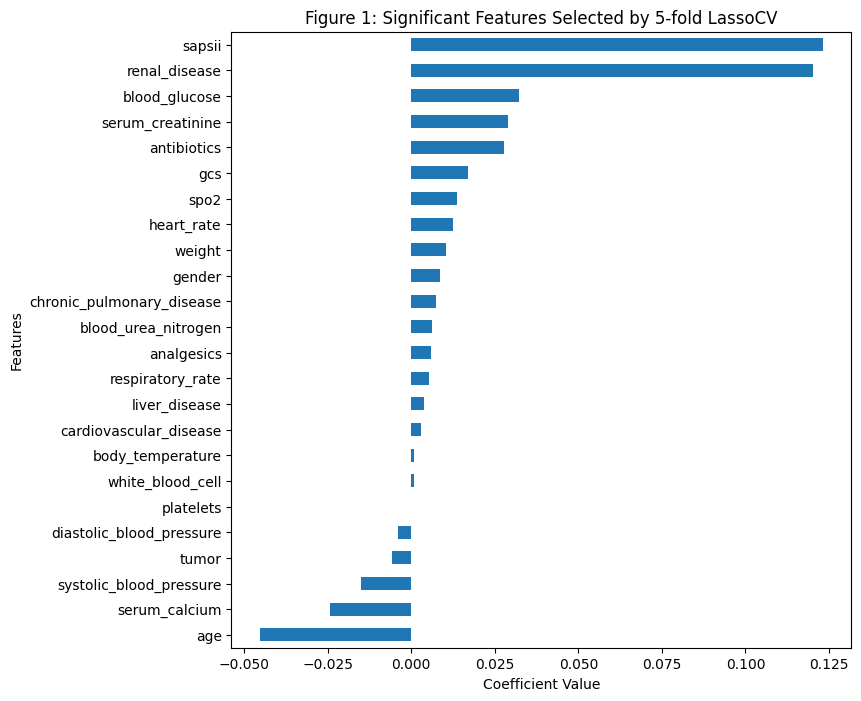

In [54]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Use LASSO regression selection with 10-fold stratified cross validation to select significant features

# Prepare data
X = imputed_htn_df.drop('aki', axis=1)
y = imputed_htn_df['aki']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state = 42)

# Stratified K-Fold for Lasso regression
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform Lasso with stratified cross-validation
lasso_cv = LassoCV(cv=skf, random_state=42).fit(X_train, y_train)

# Get the best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha found after Lasso regression selection with 5-fold cross-validation is : {best_alpha}")

# Get the coefficients of the features
lasso_coef = pd.Series(lasso_cv.coef_, index=X.columns)

# Filter significant features (non-zero coefficients)
significant_features = lasso_coef[lasso_coef != 0]
print(f"{len(significant_features)} features are significant")

# Plot the significant features
plt.figure(figsize=(8, 8))
significant_features.sort_values().plot(kind='barh')
plt.title("Figure 1: Significant Features Selected by 5-fold LassoCV")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()

### **Model training**

In [41]:
# Select these significant features into the model training
# based on the results from lasso regression (34 features)

selected_features = significant_features.index.tolist()

X = imputed_htn_df[selected_features]
y = imputed_htn_df['aki']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Data partition (Training set 75% and validation 25%)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (9049, 24)
Validation set shape: (3017, 24)


In [42]:
# Initialize ML models
models = {
    "Logistic Regression": LogisticRegression(max_iter = 1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),

    # Gaussian Naive Bayes
    "Naive Bayes": GaussianNB(),

    # SVM with radial basis function (rbf)
    "SVM": SVC(kernel='rbf', random_state=42, probability=True),

    # Random forest with 100 trees
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),

    "XGBoost": XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=100, # 100 trees
        learning_rate=0.1,
        max_depth=3, # maximum depth of tree
        random_state=42),
}

In [43]:
# Dictionary to hold the performance metrics
performance_df = pd.DataFrame()

# Train ML models
for model_name, model in models.items():
    try:
        # Fit the model
        model.fit(X_train, y_train)


        # Evaluate the model performance on validation data
        y_val_pred = model.predict(X_val)


        # Compute confusion matrix to get TN, FP, FN, TP
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
        # Compute specificity (True Negative Rate)
        specificity = tn / (tn + fp)

        # Compute accuracy
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        # Compute ROC AUC for validation data
        if hasattr(model, "predict_proba"):  # Check if the model supports probability prediction
            y_val_proba = model.predict_proba(X_val)[:, 1]  # Get the probability for the positive class
            roc_auc = roc_auc_score(y_val, y_val_proba)
        else:
            roc_auc = None  # Some models like SVM may not have predict_proba


        # # Evaluate the model performance on training data
        # y_train_pred = model.predict(X_train)
        # class_report_train = classification_report(y_train, y_train_pred, output_dict=True)
        # report_train_df = pd.DataFrame(class_report_train).transpose()

        # # Evaluate the model performance on validation data
        # y_val_pred = model.predict(X_val)
        class_report_val = classification_report(y_val, y_val_pred, output_dict=True)
        report_val_df = pd.DataFrame(class_report_val).transpose()





        # Extract 'weighted avg' values and add to the dataframe
        # train_metrics = report_train_df.loc['weighted avg'][:-1]
        val_metrics = report_val_df.loc['weighted avg'][:-1]

        # Create a DataFrame with the model name, train metrics, and val metrics
        model_metrics_df = pd.DataFrame({
            'Model': [model_name],
            'Accuracy, %': [round(accuracy * 100, 3)],
            'Sensitivity, %': [round(val_metrics['recall'] * 100, 3)],
            'Specificity, %': [round(specificity * 100, 3)],  # Add specificity
            'F1-score': [round(val_metrics['f1-score'], 3)],
            'ROC AUC': [round(roc_auc, 3) if roc_auc is not None else 'N/A']  # Add ROC AUC to the output
        })

        # Concatenate the new row with the existing performance_df
        performance_df = pd.concat([performance_df, model_metrics_df], ignore_index=True)


    except Exception as e:
        print(f"Error occurred while training {model_name}: {str(e)}")
performance_df.head(10)

,Model,"Accuracy, %","Sensitivity, %","Specificity, %",F1-score,ROC AUC
0,Logistic Regression,75.307,75.307,82.830,0.751,0.822
1,Decision Tree,65.529,65.529,67.732,0.656,0.652
2,Naive Bayes,70.401,70.401,88.573,0.688,0.787
3,SVM,74.809,74.809,85.080,0.744,0.812
4,Random Forest,74.478,74.478,82.238,0.742,0.815
5,XGBoost,74.611,74.611,82.652,0.743,0.823


##### Model tuning for Random Forest and XGBoost

Best number of trees: 500
Best AUC Score: 0.8196651507027688
Test Accuracy: 0.749751
Sensitivity: 0.749751
Specificity: 0.828301
F1-Score: 0.747089
Test AUC Score: 0.818874


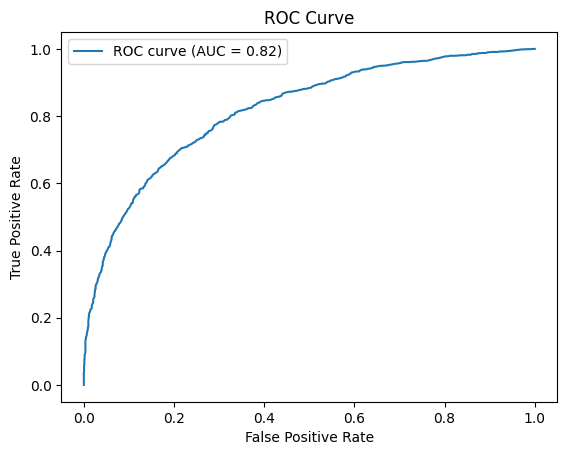

In [44]:
# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for 'n_estimators'
param_grid = {
    'n_estimators': [100, 200, 300, 500]
}

# Create StratifiedKFold object for stratified cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Set up the GridSearchCV with 5-fold cross-validation as choose roc_auc as the performance metric
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Print the best number of trees
print(f"Best number of trees: {grid_search.best_params_['n_estimators']}")
# print(f"Best cross-validation accuracy: {grid_search.best_score_}")
print("Best AUC Score:", grid_search.best_score_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Fit the best model on the training data
best_rf_model.fit(X_train, y_train)

# Predict probabilities on the test data
y_val_pred = best_rf_model.predict(X_val)
y_val_proba = best_rf_model.predict_proba(X_val)[:, 1]


# Classification report for precision, recall (sensitivity), F1-score
class_report_val = classification_report(y_val, y_val_pred, output_dict=True)
report_val_df = pd.DataFrame(class_report_val).transpose()


# Extract metrics
precision = report_val_df.loc['weighted avg']['precision']
recall = report_val_df.loc['weighted avg']['recall']  # Sensitivity
f1_score = report_val_df.loc['weighted avg']['f1-score']

# Compute confusion matrix to calculate specificity
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f"Test Accuracy: {accuracy:.6f}")
print(f"Sensitivity: {recall:.6f}")
print(f"Specificity: {specificity:.6f}")
print(f"F1-Score: {f1_score:.6f}")

# Compute the AUC score
auc = roc_auc_score(y_val, y_val_proba)
print(f"Test AUC Score: {auc:.6f}")


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# # Predict on the validation data
# y_val_pred = best_rf_model.predict(X_val)
# class_report_val = classification_report(y_val, y_val_pred, output_dict=True)
# report_val_df = pd.DataFrame(class_report_val).transpose()
# opt_rf_metrics = report_val_df.loc['weighted avg'][:-1]
# print(opt_rf_metrics)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best parameters found: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Best AUC Score: 0.8247451278835968
Test Accuracy: 0.748426
Sensitivity: 0.748426
Specificity: 0.825340
F1-Score: 0.745871
Test AUC Score: 0.818874


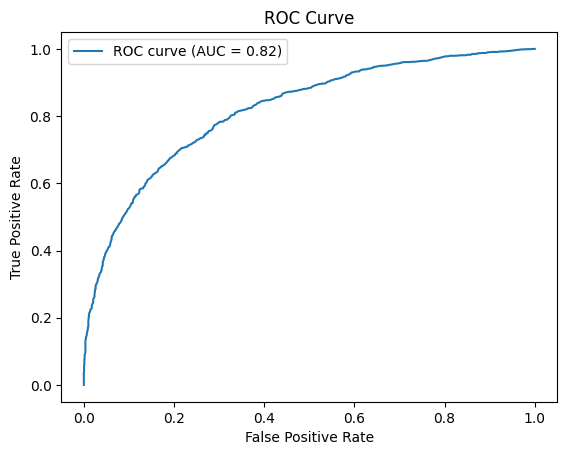

In [45]:
# Create an initial XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],  ## Step size shrinkage
    'n_estimators': [100, 200, 300, 500],     ## Number of trees
    'max_depth': [3, 5, 7, 9],                ## Maximum depth of trees
    'subsample': [0.8, 1]                   ## Subsample ratio of training instances
}

# Create StratifiedKFold object for stratified cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=skf,
                           n_jobs=-1,
                           verbose=1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best AUC Score: {grid_search.best_score_}")

# Get the best model
best_xgb_model = grid_search.best_estimator_


# Fit the best model on the training data
best_xgb_model.fit(X_train, y_train)

# Predict probabilities on the test data
y_val_pred = best_xgb_model.predict(X_val)
y_val_proba = best_rf_model.predict_proba(X_val)[:, 1]

# Classification report for precision, recall (sensitivity), F1-score
class_report_val = classification_report(y_val, y_val_pred, output_dict=True)
report_val_df = pd.DataFrame(class_report_val).transpose()


# Extract metrics
precision = report_val_df.loc['weighted avg']['precision']
recall = report_val_df.loc['weighted avg']['recall']  # Sensitivity
f1_score = report_val_df.loc['weighted avg']['f1-score']

# Compute confusion matrix to calculate specificity
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f"Test Accuracy: {accuracy:.6f}")
print(f"Sensitivity: {recall:.6f}")
print(f"Specificity: {specificity:.6f}")
print(f"F1-Score: {f1_score:.6f}")

# Compute the AUC score
auc = roc_auc_score(y_val, y_val_proba)
print(f"Test AUC Score: {auc:.6f}")


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# # Predict on the validation data
# y_val_pred = best_xgb_model.predict(X_val)
# class_report_val = classification_report(y_val, y_val_pred, output_dict=True)
# report_val_df = pd.DataFrame(class_report_val).transpose()
# opt_xgboost_metrics = report_val_df.loc['weighted avg'][:-1]
# print(opt_xgboost_metrics)

In [46]:
## update the performance matrix
performance_df.loc[performance_df['Model'] == 'Random Forest', ['Accuracy, %', 'Sensitivity, %', 'Specificity, %', 'F1-score', 'ROC AUC']] = [74.975, 74.975, 82.83, 0.747, 0.819]
performance_df.loc[performance_df['Model'] == 'XGBoost', ['Accuracy, %', 'Sensitivity, %', 'Specificity, %', 'F1-score', 'ROC AUC']] = [74.843, 74.843, 82.534, 0.746, 0.819]

## display the updated DataFrame
performance_df.head(6)

,Model,"Accuracy, %","Sensitivity, %","Specificity, %",F1-score,ROC AUC
0,Logistic Regression,75.307,75.307,82.830,0.751,0.822
1,Decision Tree,65.529,65.529,67.732,0.656,0.652
2,Naive Bayes,70.401,70.401,88.573,0.688,0.787
3,SVM,74.809,74.809,85.080,0.744,0.812
4,Random Forest,74.975,74.975,82.830,0.747,0.819
5,XGBoost,74.843,74.843,82.534,0.746,0.819


### **Model Validation**

In [47]:
class AnalysisRunner():
    def __init__(self, data):
      # Define global PrettyTables
      self.table_balance = PrettyTable()
      self.table_balance.field_names = [
          "Fold",
          "(T) 0%",
          "(T) 0 Count",
          "(T) 1%",
          "(T) 1 Count",
          "(V) 0%",
          "(V) 0 Count",
          "(V) 1%",
          "(V) 1 Count",
          "Train/Val Instances"
      ]

      self.table_results = PrettyTable()
      self.table_results.field_names = [
          "Fold",
          "Model",
          "Validation Accuracy",
          "Validation Precision",
          "Validation Sensitivity",
          "Validation Specificity",
          "Validation F1 Score"
      ]

      # Prepare features and target variable
      self.y = data['aki']  # Label
      self.x = data.drop(columns=['aki'])  # Features

      # Store metrics for aggregation
      self.model_metrics = defaultdict(lambda: {"accuracy": [], "precision": [], "sensitivity": [], "specificity": [], "f1": [], "roc_auc": []})


      self.models = {
          # Logistic regression
          "LR": LogisticRegression(max_iter = 1000, random_state=42),

          # Decision tree
          "DT": DecisionTreeClassifier(random_state=42),

          # Gaussian Naive Bayes
          "NB": GaussianNB(),

          # SVM with radial basis function (rbf)
          "SVM": SVC(kernel='rbf', random_state=42, probability=True), # probability=True for ROC


          # Random forest with 500 trees (suboptimal hyperparameter)
          "RF": RandomForestClassifier(n_estimators=500, random_state=42),


          "XGBoost": XGBClassifier(
              objective='binary:logistic',
              eval_metric='logloss',
              n_estimators=500, # 100 trees
              learning_rate=0.01,
              max_depth=5, # maximum depth of tree
              subsample=0.8,
              random_state=42)
        }


    # Add the ROC curve method
    def plotRocCurves(self, n_splits=10):

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.x)

        # Define StratifiedKFold
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Iterate through each model
        for model_name, model in self.models.items():
            tprs, fprs = [], []
            aucs = []
            # Perform K-Fold cross-validation
            for fold_idx, (train_index, val_index) in enumerate(skf.split(X_scaled, self.y), start=1):

                  x_train, x_val = X_scaled[train_index], X_scaled[val_index]
                  y_train, y_val = self.y.iloc[train_index], self.y.iloc[val_index]

                  # Train the model
                  model.fit(x_train, y_train)

                  # Predict probabilities (for ROC curve)
                  if hasattr(model, "predict_proba"):
                      y_val_proba = model.predict_proba(x_val)[:, 1]  # Probability of the positive class
                  else:
                      y_val_proba = model.decision_function(x_val)  # For models like SVM

                  # Compute ROC curve
                  fpr, tpr, _ = roc_curve(y_val, y_val_proba)
                  roc_auc = roc_auc_score(y_val, y_val_proba)
                  # Append TPR, FPR, and AUC
                  tprs.append(tpr)
                  fprs.append(fpr)
                  aucs.append(roc_auc)

            # Compute mean AUC for this model
            mean_auc = np.mean(aucs)
            self.model_metrics[model_name]["roc_auc"].append(mean_auc)
            # Plot the ROC curve for the model
            plt.plot(fprs[-1], tprs[-1], label=f"{model_name} (AUC = {mean_auc:.3f})")

        # Plot formatting
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC analysis', fontdict={'fontsize': 16, 'fontweight': 'bold'})
        plt.legend(loc="lower right")
        plt.tight_layout()

        # Save the plot to a local file
        plt.savefig('roc_analysis.png')
        plt.show()


    # Function to generate calibration curves for models
    def plotCalibrationCurves(self, n_splits=10):

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.x)

        # Define StratifiedKFold
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Iterate through each model
        for model_name, model in self.models.items():
            true_prob_list = []
            pred_prob_list = []

            # Perform K-Fold cross-validation
            for fold_idx, (train_index, val_index) in enumerate(skf.split(X_scaled, self.y), start=1):

                x_train, x_val = X_scaled[train_index], X_scaled[val_index]
                y_train, y_val = self.y.iloc[train_index], self.y.iloc[val_index]

                # Train the model
                model.fit(x_train, y_train)

                # Predict probabilities (for calibration curve)
                if hasattr(model, "predict_proba"):
                    y_val_proba = model.predict_proba(x_val)[:, 1]  # Probability of the positive class
                else:
                    y_val_proba = model.decision_function(x_val)  # For models like SVM

                # Append true labels and predicted probabilities
                true_prob_list.append(y_val)
                pred_prob_list.append(y_val_proba)

            # Flatten the lists
            true_prob_list = np.concatenate(true_prob_list)
            pred_prob_list = np.concatenate(pred_prob_list)

            # Generate calibration curve
            prob_true, prob_pred = calibration_curve(true_prob_list, pred_prob_list, n_bins=10)

            # Plot the calibration curve for this model
            plt.plot(prob_pred, prob_true, marker='o', label=f"{model_name}")

        # Plot formatting
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfectly calibrated line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Predicted Probability')
        plt.ylabel('True Probability')
        plt.title('Calibration analysis', fontdict={'fontsize': 16, 'fontweight': 'bold'})
        plt.legend(loc="lower right")
        plt.tight_layout()

        # Save the plot to a local file
        plt.savefig('calibration_analysis.png')
        plt.show()


    def doValidation(self, n_splits=10):

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.x)

        # Define StratifiedKFold
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Iterate through each fold
        for fold_idx, (train_index, val_index) in enumerate(skf.split(X_scaled, self.y), start=1):
            x_train, x_val = X_scaled[train_index], X_scaled[val_index]
            y_train, y_val = self.y.iloc[train_index], self.y.iloc[val_index]

            # Train, evaluate, and store results for each model
            for model_name, model in self.models.items():
                model.fit(x_train, y_train)
                y_val_pred = model.predict(x_val)

                # Compute confusion matrix to get TN, FP, FN, TP
                tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
                # Compute specificity (True Negative Rate)
                specificity = tn / (tn + fp)
                # Compute accuracy
                accuracy = (tp + tn) / (tp + tn + fp + fn)

                # Evaluate the model performance on validation data
                class_report_val = classification_report(y_val, y_val_pred, output_dict=True)
                report_val_df = pd.DataFrame(class_report_val).transpose()
                # Extract 'weighted avg' values and add to the dataframe
                val_metrics = report_val_df.loc['weighted avg'][:-1]

                self.model_metrics[model_name]["accuracy"].append(accuracy)
                self.model_metrics[model_name]["precision"].append(val_metrics['precision'])
                self.model_metrics[model_name]["sensitivity"].append(val_metrics['recall'])
                self.model_metrics[model_name]["specificity"].append(specificity)
                self.model_metrics[model_name]["f1"].append(val_metrics['f1-score'])

                self.table_results.add_row([
                    f"Fold {fold_idx}",
                    model_name,
                    f"{round(accuracy * 100, 3)}",
                    f"{round(val_metrics['precision'] * 100, 3)}",
                    f"{round(val_metrics['recall'] * 100, 3)}",
                    f"{round(specificity * 100, 3)}",
                    f"{round(val_metrics['f1-score'], 3)}"
                ])

    # Function to aggregate and print the model results
    def aggregate_model_results(self):

        # Define a PrettyTable for the aggregated results
        table_aggregated = PrettyTable()
        table_aggregated.field_names = [
            "Model",
            "Accuracy",
            "Precision",
            "Sensitivity",
            "Specificity",
            "F1 Score",
            "ROC AUC"
        ]

        # Calculate and add the averages for each model
        for model_name, metrics in self.model_metrics.items():
            avg_accuracy = np.mean(metrics["accuracy"])
            avg_precision = np.mean(metrics["precision"])
            avg_sensitivity = np.mean(metrics["sensitivity"])
            avg_specificity = np.mean(metrics["specificity"])
            avg_f1 = np.mean(metrics["f1"])
            avg_roc_auc = np.mean(metrics["roc_auc"]) if "roc_auc" in metrics else "N/A"

            # Add aggregated metrics to the aggregated results table
            table_aggregated.add_row([
                model_name,
                f"{avg_accuracy:.4f}",
                f"{avg_precision:.4f}",
                f"{avg_sensitivity:.4f}",
                f"{avg_specificity:.4f}",
                f"{avg_f1:.4f}",
                f"{avg_roc_auc:.4f}"
            ])
        return table_aggregated

    # # Use SHAP algorithm to interpret the importance of each feature contributing to the model prediction
    # def describeFeaturesImportance(self, input_model):


    #     # Standardize features
    #     scaler = StandardScaler()
    #     X_scaled = scaler.fit_transform(self.x)

    #     for model_name, model in self.models.items():
    #         if model_name == input_model:
    #             model.fit(X_scaled, self.yT)
    #             explainer = shap.Explainer(model)
    #             shap_values = explainer(X_scaled)




    #         else:
    #             return "Model not found"







In [48]:
# Select the label 'aki' and 24 significant features, which were derived from the Lasso regression above
selected_columns = ['aki'] + selected_features
runner = AnalysisRunner(imputed_htn_df[selected_columns])

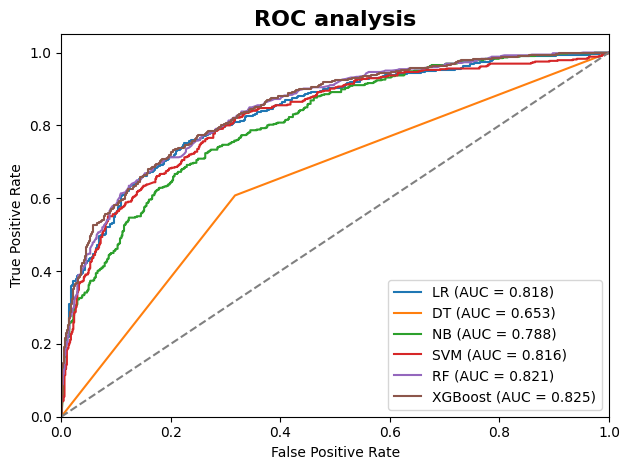

In [49]:
runner.plotRocCurves()

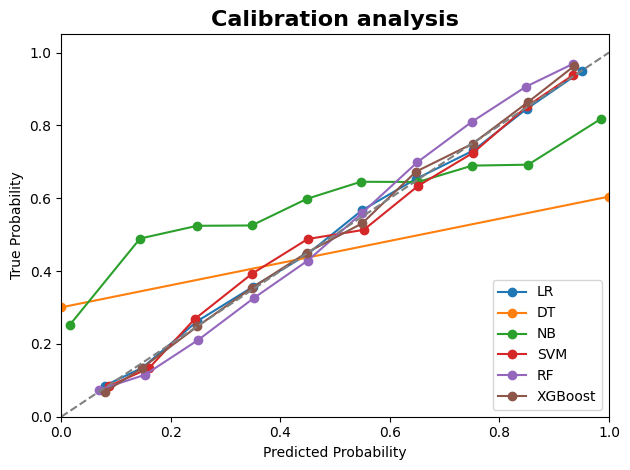

In [50]:
runner.plotCalibrationCurves()

In [51]:
# perform Kfold validation of the model set
runner.doValidation()

In [52]:
print("\nModel Results Table:")
print(runner.table_results)


Model Results Table:
+---------+---------+---------------------+----------------------+------------------------+------------------------+---------------------+
|   Fold  |  Model  | Validation Accuracy | Validation Precision | Validation Sensitivity | Validation Specificity | Validation F1 Score |
+---------+---------+---------------------+----------------------+------------------------+------------------------+---------------------+
|  Fold 1 |    LR   |        74.896       |        74.837        |         74.896         |         82.698         |        0.746        |
|  Fold 1 |    DT   |        67.026       |        67.011        |         67.026         |         70.968         |         0.67        |
|  Fold 1 |    NB   |        72.908       |        74.649        |         72.908         |         90.762         |        0.714        |
|  Fold 1 |   SVM   |        74.979       |        75.026        |         74.979         |         84.164         |        0.746        |
|  Fo

In [53]:
# Print the aggregated results table
print("\nAggregated Model Results:")
print(runner.aggregate_model_results())


Aggregated Model Results:
+---------+----------+-----------+-------------+-------------+----------+---------+
|  Model  | Accuracy | Precision | Sensitivity | Specificity | F1 Score | ROC AUC |
+---------+----------+-----------+-------------+-------------+----------+---------+
|    LR   |  0.7507  |   0.7507  |    0.7507   |    0.8321   |  0.7477  |  0.8184 |
|    DT   |  0.6575  |   0.6584  |    0.6575   |    0.6895   |  0.6577  |  0.6527 |
|    NB   |  0.7159  |   0.7281  |    0.7159   |    0.8869   |  0.7020  |  0.7878 |
|   SVM   |  0.7474  |   0.7483  |    0.7474   |    0.8440   |  0.7432  |  0.8161 |
|    RF   |  0.7498  |   0.7493  |    0.7498   |    0.8261   |  0.7472  |  0.8205 |
| XGBoost |  0.7509  |   0.7504  |    0.7509   |    0.8263   |  0.7483  |  0.8247 |
+---------+----------+-----------+-------------+-------------+----------+---------+
